#### Import required modules

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno

from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

#### Load the data, and conduct an initial exploration

In [2]:
df = pd.read_csv('UsArrests.csv')
df

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [5]:
# Check unique values for the City column
df.City.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [6]:
# Rename it to "State"
df.rename(columns={'City': 'State'}, inplace=True)

<AxesSubplot:>

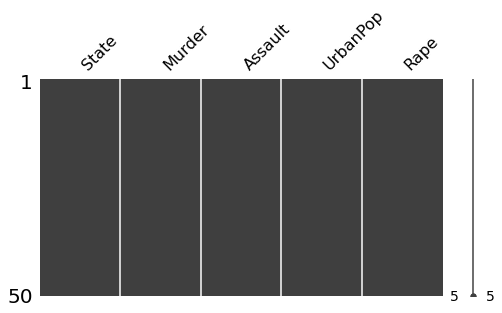

In [11]:
# Identify gaps within the dataset (if any)
missingno.matrix(df, figsize=(8,4))

It appears there are no gaps within the dataset - I can continue with the next stage of my analysis.

#### Initial visualisation of the data
Let's identify the distribution of the data.

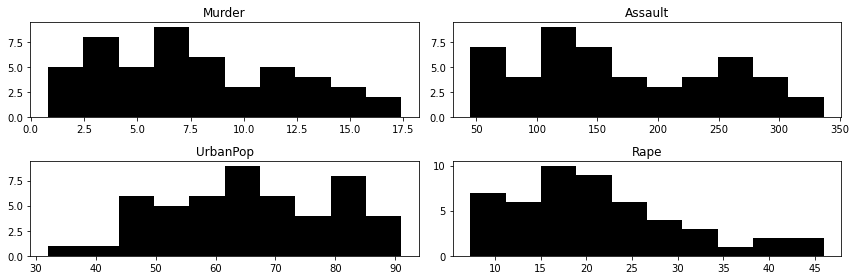

In [56]:
# Visualise the distribution of the data
hist = df.hist(color='black', grid=False, figsize=(12, 4))
plt.tight_layout()
plt.show()

Here, it appears that we have quite a range of values for each of the variables, and that in some cases they are not normally (Gaussian) distributed.

#### Correlation Analysis
What are the correlations between the variables within the dataset here?

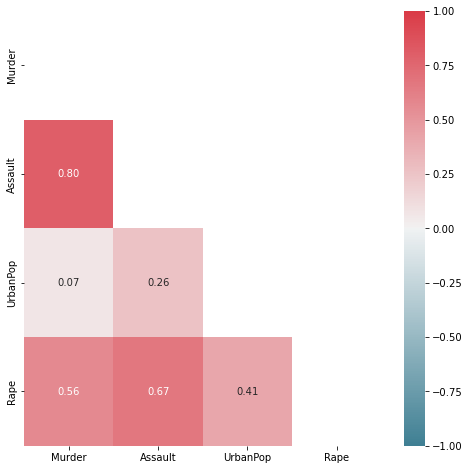

In [15]:
# Get correlations
correlations = df.corr()

# Mask mirrored side of heatmap
drop_mirror = np.zeros_like(correlations)
drop_mirror[np.triu_indices_from(drop_mirror)] = True

# Set colourmap template
colourmap = sns.diverging_palette(220, 10, as_cmap=True)

# Generate heatmap
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(correlations, cmap = colourmap, annot=True, fmt=".2f", mask=drop_mirror, vmin=-1, vmax=1)

Here, it appears there is a positive correlation between assaults and other violent crime (murder and rape). Correlations of urban populations and arrests for these violent crimes are weak however, with this strongest for rape. All of the correlations between variables here appear to be positive.

#### PCA: Unstandardised data
Let's begin with a PCA on the unstandardised dataset. This should provide us with an understanding of the underlying variables that best differentiate observations.

In [16]:
# Set independent variables
X = df.drop(["State"],axis=1).values.squeeze()

# Perform the PCA
pca = PCA()
X_trans = pca.fit_transform(X)

# Provide the transformed independent variables in a dataframe
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [18]:
# What about standard deviations?
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73240025 14.21240185  6.48942607  2.48279   ]


In [19]:
# Proportion of variance explained?
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.65534221e-01 2.78173366e-02 5.79953492e-03 8.48907879e-04]


In [20]:
# Culumative proportion?
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11485102 7213.10721735 7255.2198681  7261.38411429]


Let's plot this on a biplot, to assess the distribution of values and the strength of the different eigenvectors. First, we need to define a biplot function - for easier plotting such that I do not repeat code unnecessarily.

In [53]:
def biplot(score,coeff,labels=None, points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(15,15))    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = points[i]
        ax.annotate(txt, xy=(xs[i]* scalex, ys[i]* scaley), xytext=(xs[i]* scalex + 0.01, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

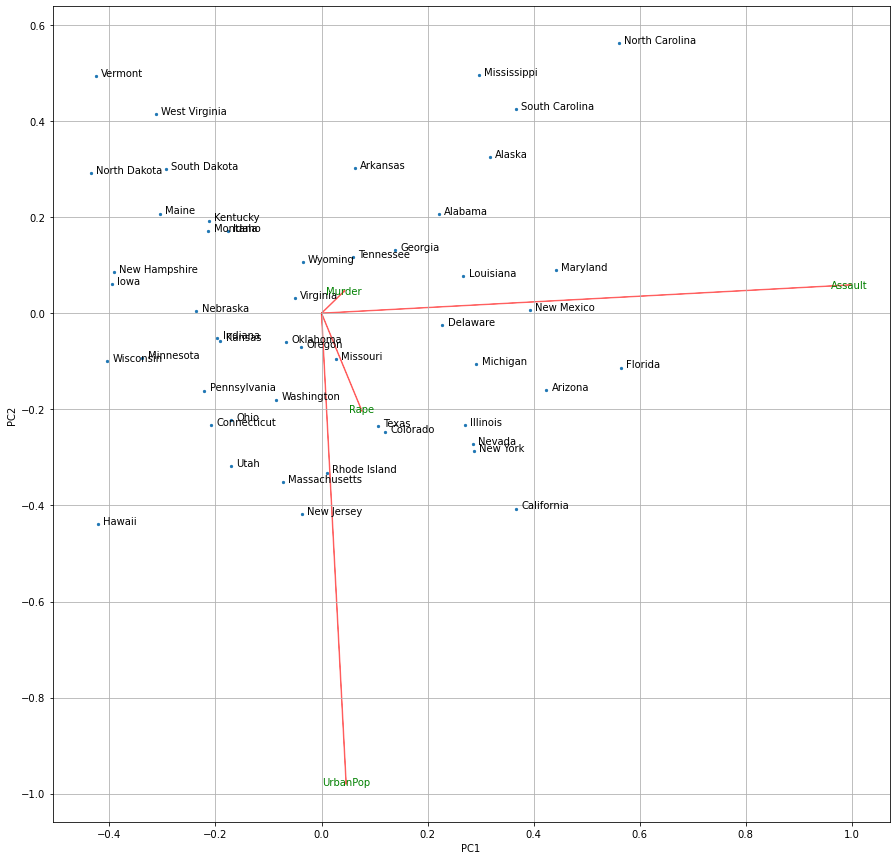

In [54]:
# Plot the biplot for the unstandardised data
labels = df.drop(["State"], axis=1)
labels = labels.columns
states = df.State.values

biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels), list(states))

Following PCA, this shows that urban population and assault arrests have the largest influence on the overall distribution of the unstandardised dataset.

#### PCA: Standardised data
Let's standardise values, so that values for each of the violent crimes are in a consistent format.

In [57]:
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


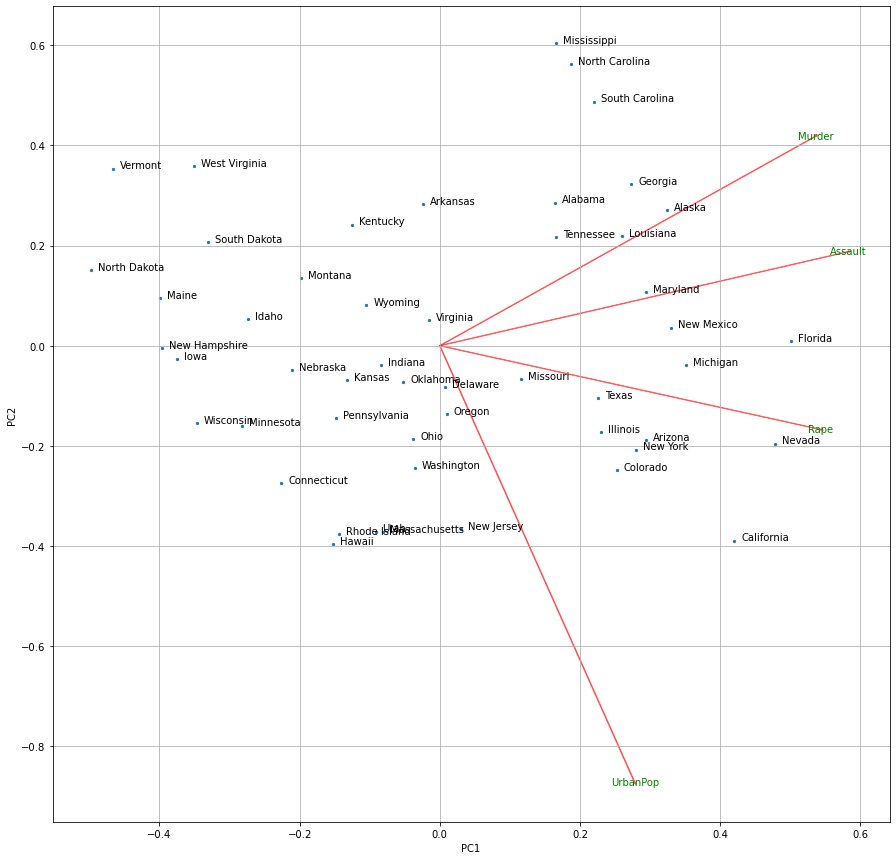

In [62]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels), list(states))

Here, the standardised data is a lot less dependent on urban population and assault values (the largest values in the dataset) to determine the distribution of the data, and results in changes in how different states are clustered.

Let's determine the culumative explained variance here in a line plot.

Text(0.5, 1.0, 'Cumulative Explained Variance')

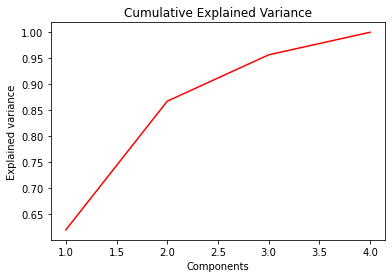

In [64]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

Whilst there are only 4 dimensions here in the first place, the standardised PCA demonstrates that two dimensions explain ~85% of the data.

What about a scree plot?

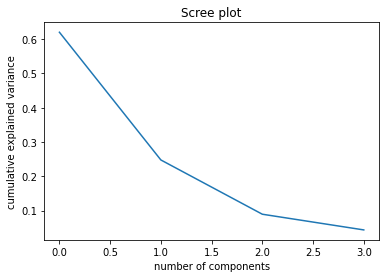

In [65]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

One component demonstrates 60% of the data, whilst the second demonstates approximately 25% of the data.

#### Hierarchical clustering

Let's begin a cluster analysis by conducting hierarchical clustering on the standardised data.

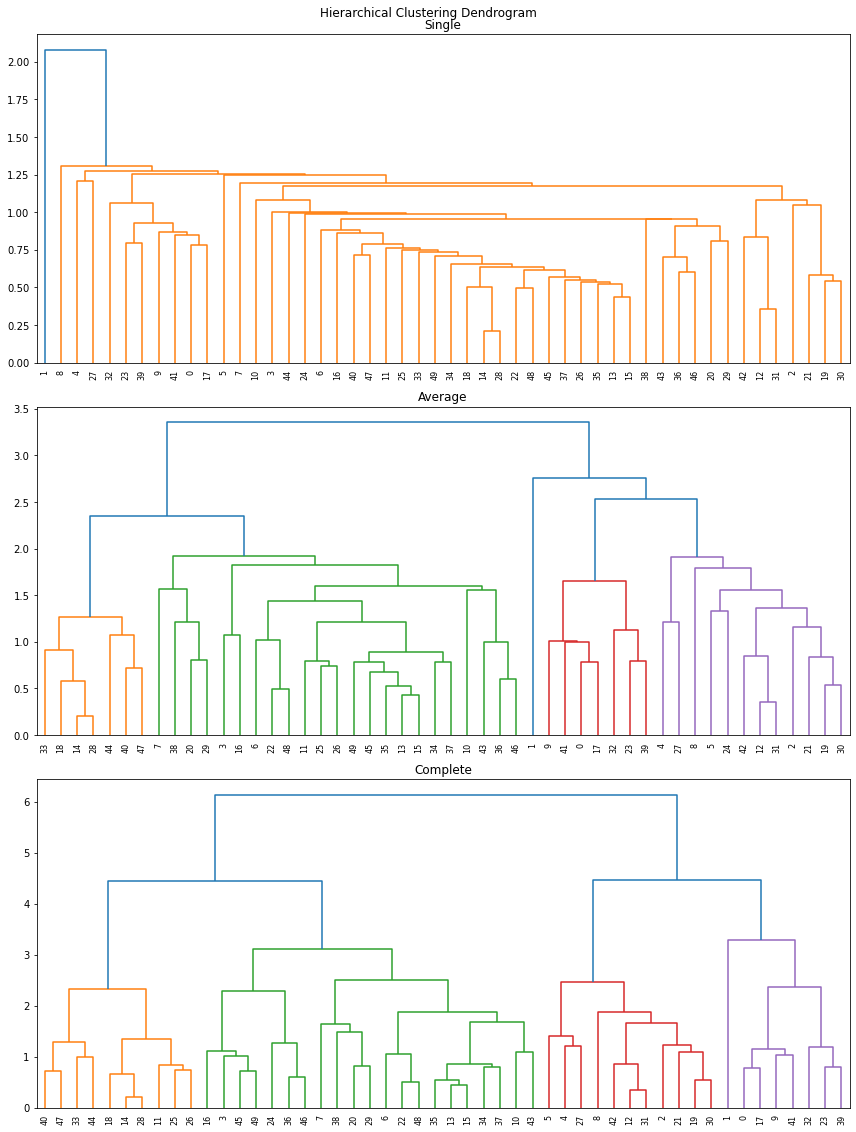

In [82]:
hc_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hc_model = hc_model.fit(df_std_pca)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,16))
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(df_std_pca, method='single'), labels=df_std_pca.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(df_std_pca, method='average'), labels=df_std_pca.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(df_std_pca, method='complete'), labels=df_std_pca.index, ax=ax3)

fig.tight_layout()
plt.show()

From the above dendograms, using the "Single" linkage method appears to provide a poor dispersion of clusters. In contrast, average and complete provide a greater dispersion of clusters, depending on the number of clusters that are required. In this case, I will use the "Complete" method for the rest of the analysis, as it provides clusters of a relatively even size overall.

#### K Means Clustering

As the spread of data in the standardised biplot appears to be quite large, and that there is no obvious values for K from this, I will select the value of K by using the "elbow method". Clustering here will be conducted on the standardised data.

C:\Users\Craig\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


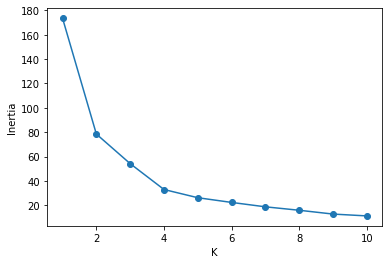

In [80]:
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x)    
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(X_std_trans[:,0:2])

The elbow here appears to run between K = 2 and K = 4. Let's analyse this further for K at these values using silouhette score. Again, let's use a function here to avoid using duplicate code.

In [128]:
# Set the x and y variable to the first two components of the PCA for the standardised data
x = X_std_trans[:,0]
y = X_std_trans[:,1]

def create_k_means(k, seed):
    # Conduct the K-means classification
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=seed)
    y_pred = kmeans.fit_predict(df_std_pca)
    
    # Calculate silouhette score
    score = round(silhouette_score(df_std_pca, kmeans.labels_, metric='euclidean'),2)
    
    # Plot
    fig = plt.figure(figsize=(12,12))
    colours = 'rbgy'
    for i in range(0,k):
        plt.scatter(x[y_pred == i],y[y_pred == i],c = colours[i]) 
    
    for i in range(0,len(x)):
        txt = states[i]
        plt.annotate(txt, xy=(x[i], y[i]), xytext=(x[i] + 0.1, y[i]))
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel("Dimension 2")
    plt.ylabel("Dimension 1")

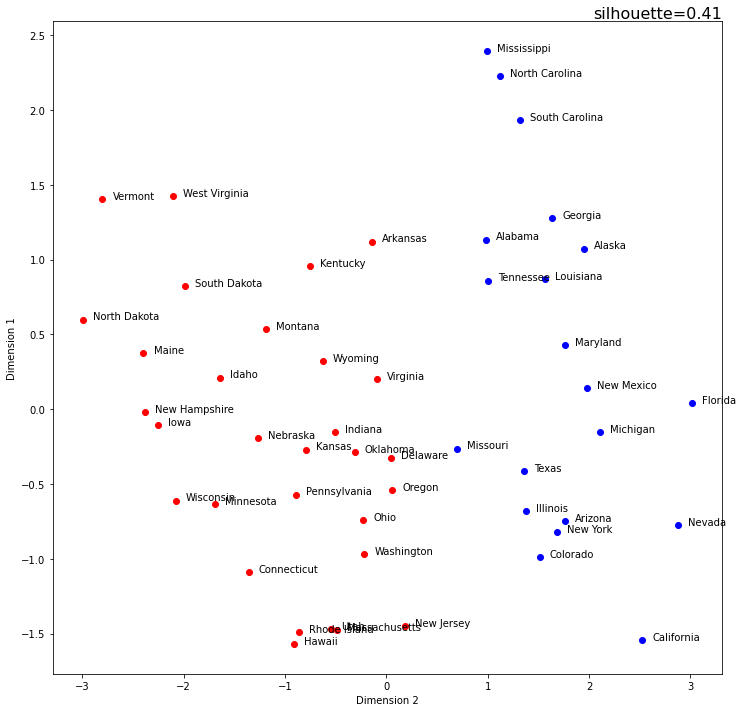

In [129]:
create_k_means(2,40000)

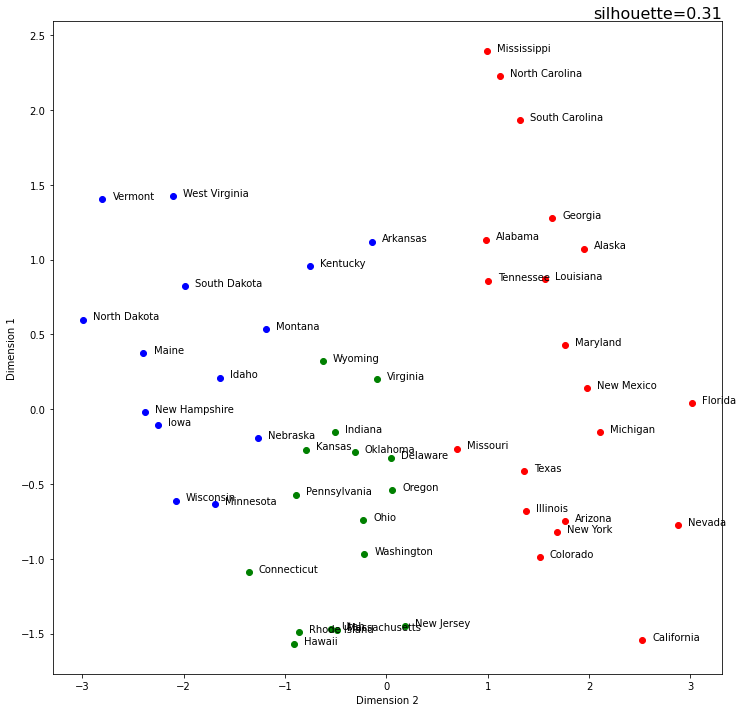

In [130]:
create_k_means(3,40000)

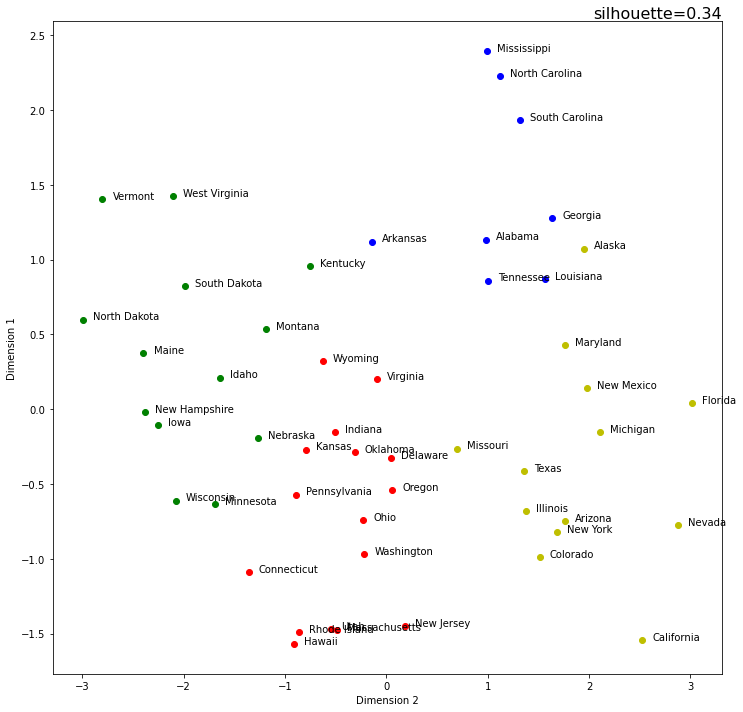

In [131]:
create_k_means(4,40000)

The best silouhette score here is obtained where K = 2. Using this cluster analysis, it can be interpreted that:
- Clusters appear to distinguish northern states vs. southern states. For example, the blue cluster contains Alabama, Tennessee, Louisiana, Texas, New Mexico, Georgia and Florida, whilst the red cluster contains most of the northern states, including Conneticut, RI, and Oregon.
- This may in fact reflect political differences, with states in the blue cluster largely containing Republican representatives, and red states largely known as Democratic strongholds. 
- The blue cluster largely contains the most populous states (e.g. California, New York, Texas).